In [2]:
import numpy as np
import ast
import pandas as pd

In [66]:

# Relaxed
results = pd.read_table('output.txt')
var = results['Optimal solution found (tolerance 1.00e-04)'][3092:4203].str.split('=').apply(lambda x: x[0])
val = results['Optimal solution found (tolerance 1.00e-04)'][3092:4203].str.split('=').apply(lambda x: x[1])

# Not relaxed / 100% initial setting
# results = pd.read_table('output22.txt')
# var = results['Optimal solution found (tolerance 1.00e-04)'][3179:4139].str.split('=').apply(lambda x: x[0])
# val = results['Optimal solution found (tolerance 1.00e-04)'][3179:4139].str.split('=').apply(lambda x: x[1])


In [70]:
t = var.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = var.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = var.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = var.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])

In [71]:
specific = pd.DataFrame(np.array([t,i,j,amount]).T).reset_index(drop=True)
specific.columns = ['t','i', 'j', 'amount']
specific[((specific['i'] == 0) & (specific['j'] == 1)) | ((specific['i'] == 1) & (specific['j'] == 0))]

,t,i,j,amount
0,0,0,1,0
1,0,0,1,1
2,0,1,0,0
3,0,1,0,1
4,1,0,1,0
...,...,...,...,...
1093,142,1,0,6
1094,143,0,1,0
1095,143,0,1,2
1096,143,0,1,3


In [72]:
specific[-(((specific['i'] == 0) & (specific['j'] == 1)) | ((specific['i'] == 1) & (specific['j'] == 0)))]

,t,i,j,amount
1062,137,1,2,10
1097,143,0,2,4
1098,143,0,2,5
1099,143,0,2,6
1100,143,0,2,7
1101,143,0,2,8
1103,143,1,2,2
1104,143,1,2,3
1105,143,1,2,4
1106,143,1,2,5


In [17]:
var = var.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
df = pd.concat([var, val],axis=1).reset_index(drop=True)
df.columns = ['var', 'val']
df['val'] = df['val'].astype(float)
df = df.groupby('var').sum().reset_index()
df['var'] = df['var']*10

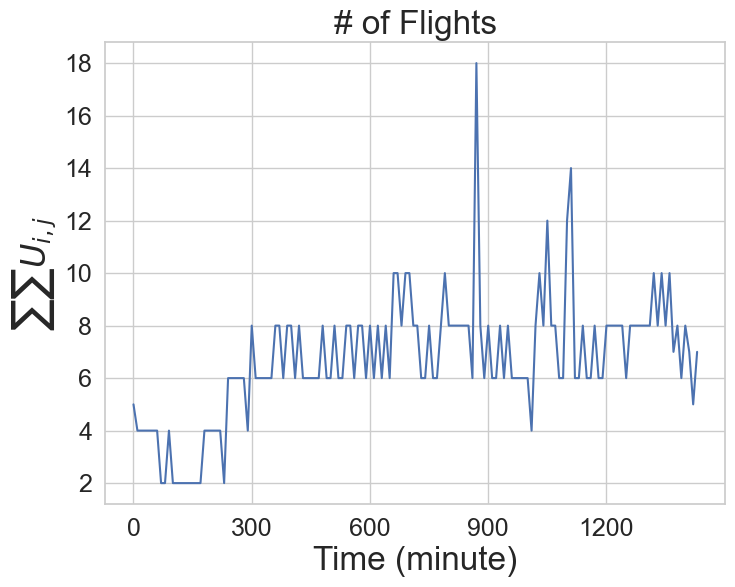

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='whitegrid', rc={'axes.labelsize': 24,
                               'xtick.labelsize': 18, 
                               'ytick.labelsize': 18, 
                               'axes.titlesize': 24,
                               'legend.title_fontsize': 24,
                               'legend.fontsize': 18,
                               })
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=df['var'], y=df['val'], ax=ax)
ax.set(xlabel='Time (minute)', ylabel='$\sum \sum U_{i,j}$',
       title='# of Flights')
ax.set_xticks(np.arange(0,1440, 300));

In [77]:
schedule = pd.read_csv('schedule.csv')
schedule['schedule'] = schedule['schedule'] // 5 * 5

In [89]:
flight_time = 10
gamma = [3.047619048 / 10, 3.047619048 / 10, 3.237872699 / 10, 3.729470167 / 10, 4.404786588 / 10, 5.379957014 / 10, 6.913363091 / 10,
        9.685271742 / 10, 16.30528373 / 10, 71.41103553 / 10]
gamma = np.array(gamma) * 10 // 5 * 5 + 5
# kappa is dropping 1 soc level



In [232]:
class aircraft:
    def __init__(self, soc, loc, unique_id, gamma=gamma):
        self.soc = soc
        self.gamma = gamma
        self.status = 'avaliable'
        self.loc = loc
        self.time = 0
        self.id = unique_id
    
    def next_state(self):
        if self.status == 'flight0':
            self.status = 'flight1'

        elif self.status == 'flight1':
            self.status = 'flight2'

        elif self.status == 'flight2':
            self.soc -= 1
            if self.soc <= 2:
                self.charge = self.gamma[self.soc:3].sum()
                self.status = 'charging'
            else:
                self.status = 'avaliable'
                
            if self.loc == 'DTLA_LAX_air':
                self.loc = 'LAX'
            elif self.loc == 'LAX_DTLA_air':
                self.loc = 'DTLA'
        
        elif self.status == 'charging':

            if self.charge == 5:
                self.status = 'avaliable'
                self.soc = 10
            else:
                self.charge -= 5

    def flight(self):
        self.status = 'flight0'
        if self.loc == 'DTLA':
            self.loc = 'DTLA_LAX_air'
        else:
            self.loc = 'LAX_DTLA_air'


In [233]:
aircrafts = []
for i in range(50):
    aircrafts.append(aircraft(10, 'DTLA', unique_id='aircraft'+str(i)))
    aircrafts.append(aircraft(10, 'LAX', unique_id='aircraft'+str(i+50)))

In [234]:
output = np.empty(shape=(288,4))

for i in range(288):
    num_lax = 0
    num_dtla = 0
    num_lax_dtla_air = 0
    num_dtla_lax_air = 0

    for aircraft in aircrafts:
        if aircraft.loc == 'LAX':
            num_lax += 1
        if aircraft.loc == 'DTLA':
            num_dtla += 1
        if aircraft.loc == 'DTLA_LAX_air':
            num_dtla_lax_air += 1
        if aircraft.loc == 'LAX_DTLA_air':
            num_lax_dtla_air += 1
            
    output[i,:] = np.array([[num_lax, num_dtla, num_lax_dtla_air, num_dtla_lax_air]])

    lax_dtla_demand = schedule[(schedule['schedule'] == i*5) & (schedule['od'] == 'LAX_DTLA')].shape[0]
    dtla_lax_demand = schedule[(schedule['schedule'] == i*5) & (schedule['od'] == 'DTLA_LAX')].shape[0]

    for j in aircrafts:
        if (j.loc == 'LAX') & (j.status == 'avaliable') & (lax_dtla_demand > 0):
            j.flight()
            lax_dtla_demand -= 1
        if (j.loc == 'DTLA') & (j.status == 'avaliable') & (dtla_lax_demand > 0):
            j.flight()
            dtla_lax_demand -= 1


    for aircraft in aircrafts:
        aircraft.next_state()


    print('currently at timestamp', i*5)


currently at timestamp 0
currently at timestamp 5
currently at timestamp 10
currently at timestamp 15
currently at timestamp 20
currently at timestamp 25
currently at timestamp 30
currently at timestamp 35
currently at timestamp 40
currently at timestamp 45
currently at timestamp 50
currently at timestamp 55
currently at timestamp 60
currently at timestamp 65
currently at timestamp 70
currently at timestamp 75
currently at timestamp 80
currently at timestamp 85
currently at timestamp 90
currently at timestamp 95
currently at timestamp 100
currently at timestamp 105
currently at timestamp 110
currently at timestamp 115
currently at timestamp 120
currently at timestamp 125
currently at timestamp 130
currently at timestamp 135
currently at timestamp 140
currently at timestamp 145
currently at timestamp 150
currently at timestamp 155
currently at timestamp 160
currently at timestamp 165
currently at timestamp 170
currently at timestamp 175
currently at timestamp 180
currently at timestamp 

<AxesSubplot:>

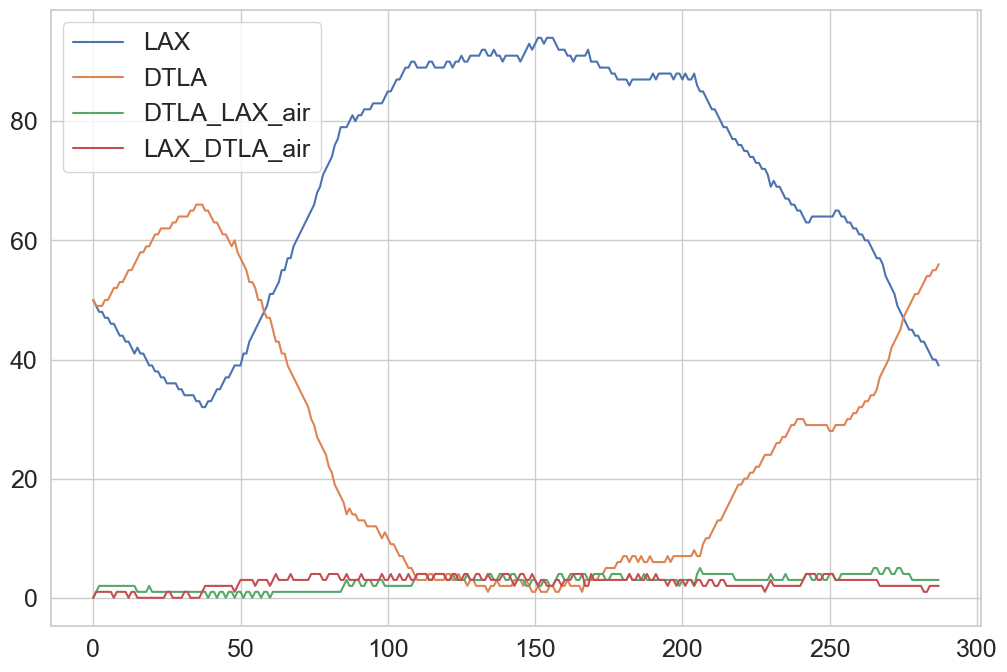

In [235]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(output[:,0], label='LAX', ax=ax)
sns.lineplot(output[:,1], label='DTLA', ax=ax)
sns.lineplot(output[:,2], label='DTLA_LAX_air', ax=ax)
sns.lineplot(output[:,3], label='LAX_DTLA_air', ax=ax)

In [103]:



class vertiport:
    def __init__(self, initial_num_aircraft):
        self.aircrafts_1 = []
        self.aircrafts_0 = []
        for i in range(initial_num_aircraft):
            self.aircrafts_1.append(aircraft(10))
            self.aircrafts_0.append(aircraft(10))

    def flight(self, num_flight, direction):
        if direction == '01':
            cnt = 0
            for i in range(direction):
                if self.aircrafts_0[i].status:
                    self.aircrafts_0[i].status = 'in_flight'
                    self.aircrafts_1.append(self.aircrafts_0[i])
                    self.aircrafts_0.pop(i)

                    cnt += 1
                if cnt == num_flight:
                    break
        
                



        self.soc = self.soc - 1
        if self.pos == 0:
            self.pos = 1
        else:
            self.pos = 0  

    def check_vertiport_status():
        pass

[1, 2, 4]